# GPR Varying Parameters

[Lawrance's thesis](http://db.acfr.usyd.edu.au/download.php/Lawrance2011_Thesis.pdf?id=2615) discusses how to learn the hyperparameters from data and also gave what parameters he came up with. Let's try to compare what hyperparameters we get with the ones he got.

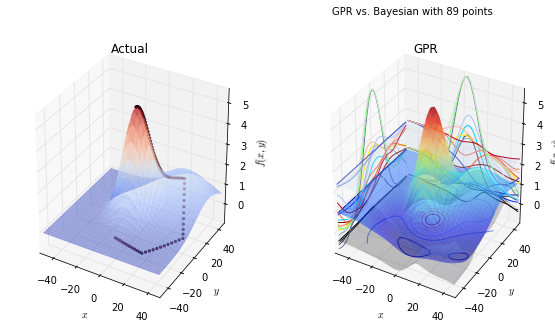

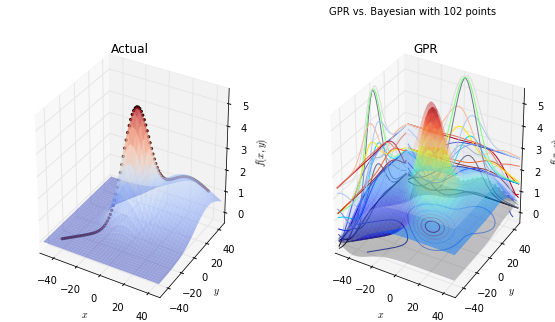

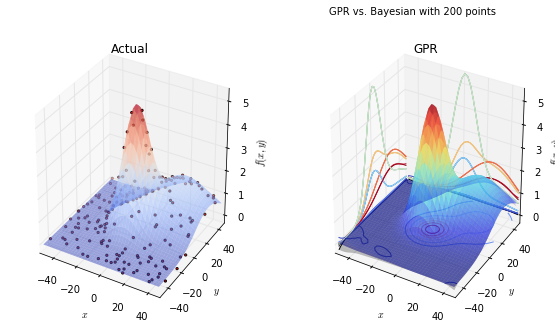

GPR Parameters: Theta0: 0.100000, ThetaL: 0.000010, ThetaU: 100000.000000, Nugget: 0.000000, RandomStart: 1
GPR MSE:
  curve: 0.349636091421
  line:  0.860679597258
  rand:  1.29601898897e-05
GPR Params:
  curve: sigma^2: [ 0.44877442] beta: [[-0.64663299]]
  line:  sigma^2: [ 0.29331865] beta: [[-0.32841359]]
  rand:  sigma^2: [ 0.41349055] beta: [[-0.27340567]]
GPR theta value (theta of scikit-learn and DACE, l of R&W and Lawrance):
  curve:  [ 0.61345956] [ 0.902801]
  line:  [ 1.68981462] [ 0.54395813]
  rand:  [ 2.09481137] [ 0.48855396]


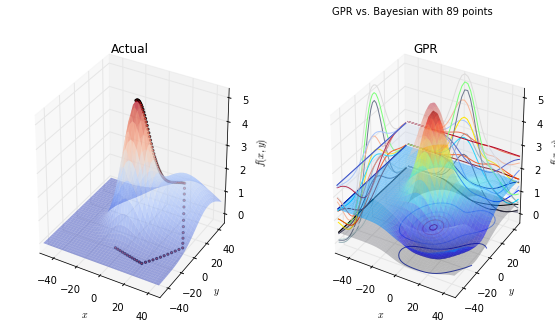

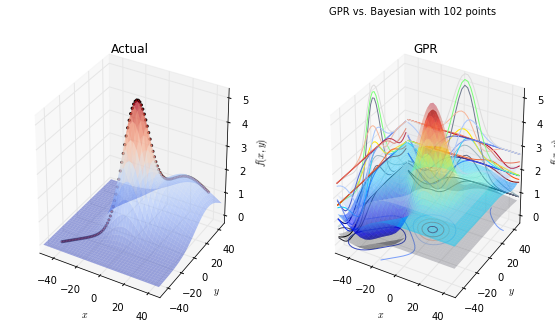

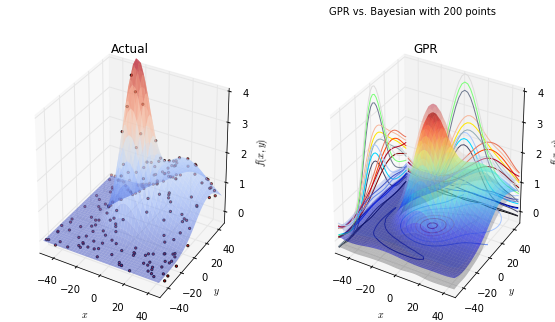

GPR Parameters: Theta0: 0.100000, ThetaL: 0.000010, ThetaU: 100000.000000, Nugget: 1.000000, RandomStart: 1
GPR MSE:
  curve: 0.98003582861
  line:  1.402668517
  rand:  0.0532084695605
GPR Params:
  curve: sigma^2: [ 0.21845189] beta: [[-0.36460668]]
  line:  sigma^2: [ 0.18061784] beta: [[-0.09878541]]
  rand:  sigma^2: [ 0.10393202] beta: [[-0.14646508]]
GPR theta value (theta of scikit-learn and DACE, l of R&W and Lawrance):
  curve:  [ 0.87911898] [ 0.75415597]
  line:  [ 2.42282187] [ 0.45428067]
  rand:  [ 2.21770168] [ 0.47482485]


In [61]:
# For calculation
import sys
import random
import numpy as np
import pymc3 as pm
import scipy as sp
import theano
import theano.tensor as t
from scipy.stats import kde
from collections import Counter
from sklearn.gaussian_process import GaussianProcess

# For visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.path import Path
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

# Display plots in Jupyter
%matplotlib inline

# For reproducibility
random.seed(126)
np.random.seed(123)

# Vertical velocity as function of the thermal's position and width
def deterministicVelocity(path, measurements, thermal_position,
                          thermal_amplitude, thermal_sd):
    # Fix "Cannot compute test value" error, see: http://stackoverflow.com/a/30241668
    #theano.config.compute_test_value = 'ignore'
    
    # Create the function but already plug in some values we want to test with
    # See: https://www.quora.com/What-is-the-meaning-and-benefit-of-shared-variables-in-Theano
    x = theano.shared(np.array([x for x,y in path]))
    y = theano.shared(np.array([y for x,y in path]))
    
    # These functions now refer to the shared variables
    # Do not compile here, see: http://stackoverflow.com/q/30426216
    def gaussianTheano(xo, yo, amplitude, sigma_x, sigma_y):
        #xo = float(xo)
        #yo = float(yo)
        theta = offset = 0 # for now
        a = (pm.cos(theta)**2)/(2*sigma_x**2) + (pm.sin(theta)**2)/(2*sigma_y**2)
        b = -(pm.sin(2*theta))/(4*sigma_x**2) + (pm.sin(2*theta))/(4*sigma_y**2)
        c = (pm.sin(theta)**2)/(2*sigma_x**2) + (pm.cos(theta)**2)/(2*sigma_y**2)
        gauss = offset+amplitude*pm.exp(-1*(a*((x-xo)**2)+2*b*(x-xo)*(y-yo)+c*((y-yo)**2)))
        return gauss
    
    # Return the Theano function that we'll use when sampling
    return gaussianTheano(thermal_position[0], thermal_position[1],
                          thermal_amplitude, thermal_sd, thermal_sd)

# Zero offset, rotation, and same sigma in both x and y
def thermalEq(position, amplitude, sd):
    return gaussian(position[0], position[1], amplitude, sd, sd, 0, 0)

# See: http://stackoverflow.com/q/25342899
def gaussian(xo, yo, amplitude, sigma_x, sigma_y, theta, offset):
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    gauss = lambda x,y: offset+amplitude*np.exp(-1*(a*((x-xo)**2)+2*b*(x-xo)*(y-yo)+c*((y-yo)**2)))
    return gauss

# Take single measurement
def takeMeasurement(field, position):
    measurement = 0

    for thermal in field:
        measurement += thermal(position[0], position[1])

    return measurement

# Take measurements at the points along the path
# Input: field=[eq1, eq2, ...], path=[(x1,y1),(x2,y2),...]
# Output: [v1, v2, ...]
def takeMeasurements(field, path):
    measurements = np.empty(len(path))
    
    for i, pos in enumerate(path):
        measurements[i] = takeMeasurement(field, pos)
    
    return measurements

#
# Create the visualization of the 3D thermal field, our path,
# and where we think the thermals are
#
def visualizeThermalField(field, path, measurements, trace, pos_min, pos_max,
                          legend=False, only2d=False, center=None,
                          fig=None, subplot=111, lines=True,
                          limits=None):
    if not fig:
        fig = plt.figure(figsize=(15,8))
    
    if only2d:
        ax = fig.add_subplot(subplot)
    else:
        ax = fig.add_subplot(subplot, projection='3d')
    
    plt.title('Bayesian')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    
    if not only2d:
        ax.set_zlabel('$f(x,y)$')
    
    # The learned values, first so they're displayed on the bottom
    plt.scatter(trace["thermal_position"][:,0], trace["thermal_position"][:,1],
                alpha=0.05, c="r")
    
    # Evaluate thermal field equations over X,Y
    # See: http://matplotlib.org/examples/mplot3d/surface3d_demo.html
    X = np.arange(pos_min, pos_max, (pos_max-pos_min)/40)
    Y = np.arange(pos_min, pos_max, (pos_max-pos_min)/40)
    X, Y = np.meshgrid(X, Y)
    Z = np.zeros((len(X),len(Y)))

    for thermal in field:
        Z += thermal(X, Y)

    if not only2d:
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                           alpha=0.5, linewidth=0, antialiased=True)

        #fig.colorbar(surf, aspect=10, shrink=0.3)

    # Contours so we can see how it compares with the path
    # See: http://matplotlib.org/examples/mplot3d/contour3d_demo3.html
    cset = ax.contour(X, Y, Z, zdir='z', offset=0, cmap=cm.coolwarm)
    #cset = ax.contour(X, Y, Z, zdir='x', offset=pos_min, cmap=cm.coolwarm)
    #cset = ax.contour(X, Y, Z, zdir='y', offset=pos_max, cmap=cm.coolwarm)
    
    # Plot the path
    # See: http://matplotlib.org/examples/mplot3d/lines3d_demo.html
    #ax.plot(X, Y, Z)
    
    # Plot the path as line segments
    # See: http://stackoverflow.com/a/11541628
    if lines:
        for i in range(1, len(path)):
            if only2d:
                ax.plot([path[i-1][0], path[i][0]], [path[i-1][1],path[i][1]],
                    label='Path Segment #'+str(i))
            else:
                ax.plot([path[i-1][0], path[i][0]], [path[i-1][1],path[i][1]],
                        zs=[0,0], label='Path Segment #'+str(i))
    
    # Otherwise, just plot the observed points
    #else:
    #    ax.scatter(path[:,0], path[:,1], measurements,
    #                c='r', marker='.', s=20, label='Observed')
    
    # Put legend outside the graph
    # See: http://stackoverflow.com/a/4701285
    if legend:
        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Display where we think the center is
    if center:
        ax.plot([center[0]], [center[1]], 'sb', markersize=10)
        # From: http://stackoverflow.com/a/5147430
        #plt.annotate("Center", xy=center, xytext=(-20, 20),
        #             textcoords='offset points', ha='right', va='bottom',
        #             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        #             arrowprops=dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    
    if limits:
        ax.set_xlim(limits[0])
        ax.set_ylim(limits[1])
        
        if not only2d:
            ax.set_zlim(limits[2])

# Compute the Maximum a posteriori estimation via how PyMC3 outputs the
# distribution via in traceplot. Probably not the best way, but it will
# find the peak that is displayed on that plot.
#
# See: https://github.com/pymc-devs/pymc3/blob/master/pymc3/plots.py
def lameMAP(data):
    density = kde.gaussian_kde(data)
    l = np.min(data)
    u = np.max(data)
    x = np.linspace(0, 1, 200) * (u - l) + l
    values = density(x)
    return x[np.argmax(values)]

#
# Use PyMC3 to determine the posterior distributions for where we believe
# a Gaussian-shaped thermal is located
#
def BayesianLearning(fig, thermals, path, measurements,
                     pos_min=-50, pos_max=50):
    with pm.Model() as model:
        # Priors
        # See: http://stackoverflow.com/q/25342899
        thermal_position = pm.Uniform('thermal_position',
                                      lower=-100, upper=100, shape=2)
        thermal_amplitude = pm.Uniform('thermal_amplitude',
                                       lower=-10, upper=10)
        thermal_sd = pm.Uniform('sd', lower=0.1, upper=100)

        # When sampling, look at the values of the test thermal field at the points
        # we have taken measurements at.
        velocity = deterministicVelocity(path, measurements,
                                         thermal_position, thermal_amplitude,
                                         thermal_sd)

        # Observe the vertical velocities
        thermal_vert_vel = pm.Normal('thermal_vert_vel', mu=velocity,
                                     observed=measurements)

        # Sample this to find the posterior, note Metropolis works with discrete
        step = pm.Metropolis()
        start = pm.find_MAP(fmin=sp.optimize.fmin_powell)
        trace = pm.sample(2000, step=step, progressbar=True, start=start)
        
        # Find the most probable surface and plot that for comparison
        x = lameMAP(trace['thermal_position'][:,0])
        y = lameMAP(trace['thermal_position'][:,1])
        amp = lameMAP(trace['thermal_amplitude'])
        sd = lameMAP(trace['sd'])
        eq = thermalEq((x,y), amp, sd)
        
        # Plot it
        prev = plt.gca()
        visualizeThermalField([eq], path, measurements, trace, pos_min, pos_max,
                              only2d=False, fig=fig, subplot=133, lines=False,
                              limits=[prev.get_xlim(),prev.get_ylim(),prev.get_zlim()])
        
        # Really, we have more information than just this MAP estimate.
        # We have probability distributions over all the parameters.
        # It's hard to visualize this in one figure that we can directly
        # compare with the GPR though.
        pm.traceplot(trace, ['thermal_position','thermal_amplitude','sd'])
        #visualizeThermalField(thermals, path, trace, -50, 50, only2d=False)
        #visualizeThermalField(thermals, path, trace, -50, 50, only2d=True)

# Comments from documentation:
# http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcess.html
class GPRParams:
    def __init__(self, theta0=1e-1, thetaL=None, thetaU=None,
                 nugget=None, random_start=1):
        # Since thetaL and thetaU are specified, theta0 is the starting point
        # for the maximum likelihood estimation of the best set of parameters
        #
        # Default assumes isotropic autocorrelation model with theta0 = 1e-1
        self.theta0 = theta0
        
        # Lower bound on the autocorrelation parameters for maximum likelihood
        # estimation
        #
        # Default is None, so that it skips maximum likelihood estimation and
        # it uses theta0
        self.thetaL = thetaL
        
        # Upper bound on the autocorrelation parameters for maximum likelihood
        # estimation
        #
        # Default is None, so that it skips maximum likelihood estimation and
        # it uses theta0
        self.thetaU = thetaU
        
        # Introduce a nugget effect to allow smooth predictions from noisy data.
        # If nugget is an ndarray, it must be the same length as the number of
        # data points used for the fit. The nugget is added to the diagonal of
        # the assumed training covariance
        #
        # Default assumes a nugget close to machine precision for the sake of
        # robustness (nugget = 10. * MACHINE_EPSILON)
        self.nugget = nugget
        
        # The number of times the Maximum Likelihood Estimation should be performed
        # from a random starting point
        #
        # Default does not use random starting point (random_start = 1)
        self.random_start = random_start
    
    # For debugging, when printing
    def __str__(self):
        return "Theta0: %f, ThetaL: %f, ThetaU: %f, Nugget: %f, RandomStart: %d" % (
            self.theta0, self.thetaL, self.thetaU, self.nugget, self.random_start)

#
# Compute mean-squared error (MSE)
#
def evalMSE(predicted, correct):
    p = predicted.flatten()
    c = correct.flatten()
    n = len(p)
    assert len(p)==len(c)
    return 1.0/n*sum(np.square(p-c))

#
# Gaussian Process Regression to learn thermals
#
def GaussianProcessRegression(fig, field, path, measurements,
                              pos_min=-50, pos_max=50, gprParams=None):
    X = path
    y = measurements
    
    if gprParams == None:
        gprParams = GPRParams()

    # Generate all the points we want to output at
    # See: http://stackoverflow.com/a/32208788
    grid_x, grid_y = np.meshgrid(
        np.arange(pos_min, pos_max, (pos_max-pos_min)/40),
        np.arange(pos_min, pos_max, (pos_max-pos_min)/40))
    grid = np.vstack((grid_x.flatten(), grid_y.flatten())).T
    
    Z = np.zeros((len(grid_x),len(grid_y)))

    for thermal in field:
        Z += thermal(grid_x, grid_y)

    #
    # Doesn't work as well. Not sure why:
    #  gp = GaussianProcess(corr='cubic', theta0=1e-2, thetaL=1e-4, thetaU=1e-1,
    #                       random_start=100)
    #
    """
    gp = GaussianProcess(corr='squared_exponential', theta0=1e-1,
                     thetaL=1e-3, thetaU=1,
                     nugget=2*np.ones(len(y)), # No idea what this does... but if it's too low it errors
                     random_start=100)
    """
    gp = GaussianProcess(corr='squared_exponential',
                         theta0=gprParams.theta0,
                         thetaL=gprParams.thetaL,
                         thetaU=gprParams.thetaU,
                         nugget=gprParams.nugget,
                         random_start=gprParams.random_start)

    # Regression, fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X, y)

    # Prediction over our grid
    prediction, MSE = gp.predict(grid, eval_MSE=True)
    sigma = np.sqrt(MSE)
    
    # Plot the predicted values
    plt.suptitle("GPR vs. Bayesian with "+str(len(measurements))+" points")
    
    ax = fig.add_subplot(1,3,2, projection='3d')
    plt.title('GPR')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$f(x,y)$')
    
    # Reshape from 1D to 2D so we can plot these
    pred_surface = prediction.reshape(len(grid_x), len(grid_y))
    sigma_surface = sigma.reshape(len(grid_x), len(grid_y))
    
    # The mean
    ax.plot_surface(grid_x, grid_y, pred_surface, label='Prediction',
                    rstride=1, cstride=1, cmap=cm.jet,
                    alpha=0.5, linewidth=0, antialiased=True)

    # 95% Confidence Interval
    lower = np.add(pred_surface, -1.9600*sigma_surface)
    upper = np.add(pred_surface, 1.9600*sigma_surface)
    
    ax.plot_surface(grid_x, grid_y, lower,
                    label='Lower 95% Confidence Interval',
                    rstride=1, cstride=1, cmap=cm.bone,
                    alpha=0.25, linewidth=0, antialiased=True)
    ax.plot_surface(grid_x, grid_y, upper, 
                    label='Upper 95% Confidence Interval',
                    rstride=1, cstride=1, cmap=cm.coolwarm,
                    alpha=0.25, linewidth=0, antialiased=True)
    
    # Contours so we can see how it compares with the path
    # See: http://matplotlib.org/examples/mplot3d/contour3d_demo3.html
    cset = ax.contour(grid_x, grid_y, pred_surface, zdir='z', offset=0, cmap=cm.coolwarm)
    cset = ax.contour(grid_x, grid_y, lower, zdir='x', offset=pos_min, cmap=cm.bone)
    cset = ax.contour(grid_x, grid_y, lower, zdir='y', offset=pos_max, cmap=cm.bone)
    cset = ax.contour(grid_x, grid_y, pred_surface, zdir='x', offset=pos_min, cmap=cm.jet)
    cset = ax.contour(grid_x, grid_y, pred_surface, zdir='y', offset=pos_max, cmap=cm.jet)
    cset = ax.contour(grid_x, grid_y, upper, zdir='x', offset=pos_min, cmap=cm.coolwarm)
    cset = ax.contour(grid_x, grid_y, upper, zdir='y', offset=pos_max, cmap=cm.coolwarm)
    
    # Now for the actual values
    ax2 = fig.add_subplot(1,3,1, projection='3d')
    plt.title('Actual')
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$y$')
    ax2.set_zlabel('$f(x,y)$')
    
    ax2.plot_surface(grid_x, grid_y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                    alpha=0.5, linewidth=0, antialiased=True)
    
    # Plot the observed measurements
    ax2.scatter(path[:,0], path[:,1], measurements, c='r', marker='.', s=20, label='Observed')
    
    # Use the same scale
    ax2.set_xlim(ax.get_xlim())
    ax2.set_ylim(ax.get_ylim())
    ax2.set_zlim(ax.get_zlim())
    
    return (evalMSE(pred_surface, Z), gp.reduced_likelihood_function(), gp.theta_)

#
# Take a list of points and add the specified number of points
# in between every set of two points linearly
#
def morePoints(path, num):
    newPath = []
    
    # Add points between each pair
    for i in range(1, len(path)):
        prev = path[i-1]
        cur  = path[i]
        
        # Add the first point
        newPath.append(prev)
        
        # Calculate the vector toward the next point
        towardCurrent = np.subtract(cur, prev)
        distance = np.linalg.norm(towardCurrent)
        towardCurrentNorm = towardCurrent / np.linalg.norm(towardCurrent)
        eachStep = distance/(num+1)
        
        # Go the right proportion along it the right number of times
        # to insert the specified number of points between
        for j in range(0, num):
            newPosition = prev + (j+1)*eachStep*towardCurrentNorm
            newPath.append(tuple(newPosition))
        
    # Append the last point as well
    newPath.append(path[-1])
    
    return np.array(newPath)

#
# Run both techniques on one path
#
def RunPath(thermals, path, gprParams=None):
    fig = plt.figure(figsize=(15,5))
    measurements = takeMeasurements(thermals, path)
    gpr = GaussianProcessRegression(fig, thermals, path,
                                        measurements, gprParams=gprParams)
    #BayesianLearning(fig, thermals, path, measurements)
    plt.show()
    
    return gpr

#
# Describe the thermal field and a path through it, learn the thermal field
# using different techniques
#
def MultiplePaths(gprParams=None):
    thermals = [thermalEq((0,0), 5, 10),
                    thermalEq((25,25), 2, 20)]
    
    # Some curve
    path = np.array([(0,0), (5,5), (10,10), (15,12), (20,15),
            (30,20), (45,-10), (25,-35), (0,-30)])
    #RunPath(thermals, path)
    
    # More points on curve
    gpr_curve = RunPath(thermals, morePoints(path, 10), gprParams)
    
    # Straight line
    line = np.array([(-40,-40),(40,40)])
    #RunPath(thermals, morePoints(line, 10))
    
    # More points on straight line
    gpr_line = RunPath(thermals, morePoints(line, 100), gprParams)
    
    # Random points between +50 and -50
    randpath = 100*np.random.random((200,2))-50
    gpr_rand = RunPath(thermals, randpath, gprParams)
    
    print("GPR Parameters:", gprParams)
    print("GPR MSE:")
    print("  curve:", gpr_curve[0])
    print("  line: ", gpr_line[0])
    print("  rand: ", gpr_rand[0])
    print("GPR Params:")
    print("  curve: sigma^2:", gpr_curve[1][1]["sigma2"], "beta:", gpr_curve[1][1]["beta"])
    print("  line:  sigma^2:", gpr_line[1][1]["sigma2"], "beta:", gpr_line[1][1]["beta"])
    print("  rand:  sigma^2:", gpr_rand[1][1]["sigma2"], "beta:", gpr_rand[1][1]["beta"])
    print("GPR theta value (theta of scikit-learn and DACE, l of R&W and Lawrance):")
    print("  curve: ", gpr_curve[2], 1.0/np.sqrt(2*gpr_curve[2]))
    print("  line: ", gpr_line[2], 1.0/np.sqrt(2*gpr_line[2]))
    print("  rand: ", gpr_rand[2], 1.0/np.sqrt(2*gpr_rand[2]))
    
    return (gpr_curve, gpr_line, gpr_rand)

def ParameterTests():
    # theta0 - changed on order of 1e-5 when random_start 100,
    #          changed by 0 if random_start=1
    # thetaL - highly spiked if this is too high
    # thetaU - If this is too low, bizarre results, very unconfident
    # nugget - Affects how smooth the results are
    # random_start - 1 vs. 100 changed MSE on the order of 1e-5
    
    MultiplePaths(GPRParams(
        theta0=1e-1,
        thetaL=1e-5,
        thetaU=1e5,
        nugget=1e-10,
        random_start=1))
    
    MultiplePaths(GPRParams(
        theta0=1e-1,
        thetaL=1e-5,
        thetaU=1e5,
        nugget=1,
        random_start=1))

# Use MSE to compare parameters
# Later: Actual performance of plane, how well goes to center, how long stays up, etc.
# Todo: Use data on GDrive
ParameterTests()

### Comparison
On page 150 of [Lawrance's 2011 thesis](http://db.acfr.usyd.edu.au/download.php/Lawrance2011_Thesis.pdf?id=2615), a table is given. For a seperable covariance function when dealing with time, l_x = 0.7538 and sigma_f = 0.2040. In the above code with GPR parameters of [Theta0: 0.100000, ThetaL: 0.000010, ThetaU: 100000.000000, Nugget: 1.000000, RandomStart: 1], the l value is 0.75415597 for the curved path. This is fairly close. And, sigma = sqrt(0.21845189) = 0.467388371699596, which is the same order of magnitude as sigma_f though not as close as l.

Note: I believe l = 1/sqrt(2\*theta) when comparing the Matlab DACE toolbox (which is what scikit-learn's GPR was based on) with Lawrance's equations.

While the table was providing values involving a time dimension as well (hence seperable vs. non-seperable), the seperable values I would think would be comparable to when not dealing with the time dimension.